# Implementing a New Group

Implementing a new group equivariance in our library is fairly straightforward. 
You need to specify the discrete and continuous generators of the group in a given representation: $\rho(h_i)$ and $d\rho(A_k)$, and then call the init method. These two fields, `self.discrete_generators` and `self.lie_algebra` should be a sequence of square matrices. These can either be specified as dense arrays (such as through `np.ndarray`s of size `(M,n,n)` and `(D,n,n)`) or as `LinearOperator` objects that implement matmul lazily. In general it's possible to implement any matrix group, and we'll go through a few illustrative examples. After checking out these examples, you can browse through the implementations for many other groups [here](https://github.com/mfinzi/equivariant-MLP/blob/master/emlp/solver/groups.py).

## Discrete Group Example: Alternating Group $A_n$

The alternating group $A_n$ is a discrete group that contains all _even_ permutations from the permutation group $S_n$. There are many different generating sets that we could use, but let's for example choose the [generators](https://math.stackexchange.com/questions/1358030/set-of-generators-for-a-n-the-alternating-group) $(123),(124),...,(12n)$ where each term is a cyclic permutation of those indices. So to implement the group, all we need to do is specify these generators.

In [5]:
#import logging; logging.getLogger().setLevel(logging.INFO)
from emlp.solver.groups import Group,S
from emlp.solver.representation import V,T,vis
import numpy as np

class Alt(Group): 
    """ The alternating group in n dimensions"""
    def __init__(self,n):
        assert n>2
        self.discrete_generators = np.zeros((n-2,n,n))+np.eye(n) # init an array of n-2 identity matrices
        for i in range(n-2):
            ids = (0,1,i+2)
            permed_ids = np.roll(ids,1) # cyclic permutation (0,1,i+2)->(i+2,0,1)
            self.discrete_generators[i,ids] = self.discrete_generators[i,permed_ids]
        super().__init__(n)

High rank objects for $Alt(n)$ have additional equivariant solutions compared to the permutation group $S_n$ that contains it.

In [2]:
print("T5 basis for Alt(5) of shape ",T(5)(Alt(5)).symmetric_basis().shape)
print("T5 basis for S(5) of shape ",T(5)(S(5)).symmetric_basis().shape)

T5 basis for Alt(5) of shape  (3125, 63)
T5 basis for S(5) of shape  (3125, 52)


You can verify the equivariance:

In [3]:
from emlp.tests.equivariant_subspaces_tests import rel_error
G = Alt(5)
rep = T(5)(G)
Q = rep.symmetric_basis()
gQ = rep.rho(G.sample())@Q
rel_error(Q,gQ)

DeviceArray(1.0878562e-06, dtype=float32)

## Continuous Group Example: Special Orthogonal Group $\mathrm{SO}(n)$

Many Lie groups lie in the image of the exponential map. A classic example is the special orthogonal group $SO(n)$ consisting of rotations in $n$ dimensions: $\mathrm{SO}(n) = \{R \in \mathbb{R}^{n\times n}: R^TR=I, \mathrm{det}(R)=1\}$. Because this is a continuous group, we need to specify the Lie Algebra, which can be found by differentiating the constraints at the identity or simply by looking it up on [wikipedia](https://en.wikipedia.org/wiki/3D_rotation_group#Lie_algebra). $\mathfrak{so}(n) = T_\mathrm{id}\mathrm{SO}(n) = \{A\in \mathbb{R}^{n\times n}: A^\top=-A \}$. We can choose any basis for this $n(n-1)$ dimensional subspace of antisymmetric matrices. Since $\mathrm{exp}(\mathfrak{so}(n)) = \mathrm{SO}(n)$, this is all we need to specify.

In [4]:
class SO(Group): #
    def __init__(self,n):
        """ The special orthogonal group SO(n) in n dimensions"""
        self.lie_algebra = np.zeros(((n*(n-1))//2,n,n))
        k=0
        for i in range(n):
            for j in range(i):
                self.lie_algebra[k,i,j] = 1
                self.lie_algebra[k,j,i] = -1
                k+=1
        super().__init__(n)

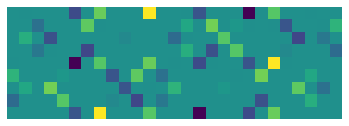

In [5]:
vis(V(SO(3))**3,V(SO(3))**2,cluster=False)

## Lie Group with Multiple Connected Components Example: $\mathrm{O}(n)$ 

Lie groups that are not in the image of the exponential map can be a bit more complicated because they often need to be constructued with both continuous and discrete generators. A good example is the orthogonal group $\mathrm{O}(n)$ consisting of rotations and reflections $\mathrm{O}(n) = \{R \in \mathbb{R}^{n\times n}: R^TR=I\}$. The Lie algebra for $\mathrm{O}(n)$ is the same as for $\mathrm{SO}(n)$. $\mathfrak{o}(n)=\mathfrak{so}(n)$ and so $\mathrm{exp}(\mathfrak{o}(n)) = \mathrm{SO}(n) \ne \mathrm{O}(n)$. Instead, the orthogonal group has $2$ connected components: orthogonal matrices with $\mathrm{det}(R)=1$ and $\mathrm{det}(R)=-1$, and so we need a generator to traverse between the two components such as $h = \begin{bmatrix}-1 &0\\ 0 & I\\
\end{bmatrix}$. We can reuse the Lie algebra implementation from $\mathrm{SO}(n)$ and implement the additional discrete generator below.

In [6]:
class O(SO): #
    def __init__(self,n):
        """ The Orthogonal group O(n) in n dimensions"""
        self.discrete_generators = np.eye(n)[None]
        self.discrete_generators[0,0,0]=-1
        super().__init__(n)

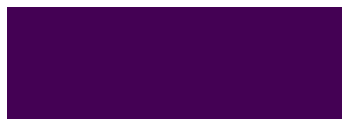

In [7]:
vis(V(O(3))**3,V(O(3))**2,cluster=False); #Unlike SO(n), O(n) has no solutions for odd parity V^3->V^2 = T5 = odd

## Accelerating the solver using lazy matrices

For larger representations our solver uses an iterative method that benefits from faster multiplies with the generators. Instead of specifying the generators using dense matrices, you can specify them as `LinearOperator` objects in a way that makes use of known structure (like sparsity, permutation, etc). These LinearOperator objects are modeled after [scipy Linear Operators](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html) but adapted to be compatible with jax and with some additional features.

Returning to the alternating group example, we can specify the generators as permutation operators directly. There are many useful LinearOperators implemented in `LinearOperator` which we recommend using if available, but we will go through the minimum steps for implementing a new operator like Permutation as an example.

Note that you need to be using quite large representations before any speedups will be felt due to the increased compile times with Jax (we are hoping to speed this up).

In [1]:
from emlp.solver.linear_operator_jax import LinearOperator
import numpy as np

class LazyPerm(LinearOperator):
    def __init__(self,perm):
        self.perm=perm
        self.shape = (len(perm),len(perm))
    def _matmat(self,V):
        return V[self.perm]
    def _matvec(self,V):
        return V[self.perm]
    def _adjoint(self):
        return LazyPerm(np.argsort(self.perm))

In [2]:
class AltFast(Group): 
    """ The alternating group in n dimensions"""
    def __init__(self,n):
        assert n>2
        perms =np.zeros((n-2,n)).astype(int)+np.arange(n)[None]
        for i in range(n-2):
            ids = (0,1,i+2)
            permed_ids = np.roll(ids,1) # cyclic permutation (0,1,i+2)->(i+2,0,1)
            perms[i,ids] = perms[i,permed_ids]
        self.discrete_generators = [LazyPerm(perm) for perm in perms]
        super().__init__(n)

In [3]:
#import logging; logging.getLogger().setLevel(logging.INFO)

In [6]:
%timeit -n1 -r1 T(2)(Alt(100)).symmetric_basis()

Krylov Solving for Equivariant Subspace r<=10:   0%|          | 0/100 [00:00<?, ?it/s]

17.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
%timeit -n1 -r1 T(2)(AltFast(100)).symmetric_basis()

Krylov Solving for Equivariant Subspace r<=10:   0%|          | 0/100 [00:00<?, ?it/s]

29.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
